# OkNLP

In [1]:
import warnings

import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from utils.categorize_demographics import *
from utils.clean_up import clean_up
from utils.distinctive_tokens import log_odds_ratio
from utils.lexical_features import *
from utils.nonnegative_matrix_factorization import nmf_labels, nmf_inspect
from utils.plotting import lollipop_paper
from utils.splits import *
from utils.text_representation import feature_vectors


warnings.filterwarnings('ignore')

%matplotlib inline

## Data

In [2]:
df = pd.read_csv('data/profiles.20120630.csv')

essay_list = ['essay0', 'essay4']
df_0, df_4 = clean_up(df, essay_list)

df_0 = recategorize(df_0)
df_4 = recategorize(df_4)

## Lexical

Based on the universal tagset of Petrov, Das, & McDonald ([link](https://github.com/slavpetrov/universal-pos-tags)).

```
ADJ - adjectives
ADP - adpositions (prepositions and postpositions)
ADV - adverbs
CONJ - conjunctions
DET - determiners
NOUN - nouns (common and proper)
NUM - cardinal numbers
PART - particles or other function words
PRON - pronouns
PUNCT - punctuation
VERB - verbs (all tenses and modes)
X - other: foreign words, typos, abbreviations
```

spaCy-specific information: https://spacy.io/docs#token-postags.

In [3]:
pos = pos_df(df_0.essay0)
pos_norm = pos_normalize(pos)

### Essay Length

In [4]:
pos['n_tokens'] = pos.sum(axis=1)
pos_by_split(df_0, pos, 'sex', ['n_tokens'], print_levels=True)

Levels (in order): ['F' 'M']

n_tokens
[means] 'a': 149.58946578 'b': 138.72696526
p-values:
  [permutation]: 0.0
  [classical]:   0.0



### Profanity and Slang

In [5]:
profane = load_words('data/profane.txt')
profanity = pd.DataFrame(contains(profane, df_0.essay0),
                         columns=['profanity'])
print(profanity.profanity.sum() / profanity.shape[0])
pos_by_split(df_0, profanity, 'sex', ['profanity'])

0.0600098191019
profanity
[means] 'a': 0.05815862 'b': 0.06125739
p-values:
  [permutation]: 0.1439
  [classical]:   0.1390202



In [6]:
slang = load_words('data/slang.txt')
slang = pd.DataFrame(contains(slang, df_0.essay0),
                     columns=['slang'])
print(slang.slang.sum() / slang.shape[0])
pos_by_split(df_0, slang, 'sex', ['slang'])

0.559084557574
slang
[means] 'a': 0.5411097 'b': 0.57119828
p-values:
  [permutation]: 0.0
  [classical]:   0.0



### Adjectives, Nouns, and Verbs

In [7]:
pos_by_split(df_0, pos_norm, 'sex', ['ADJ', 'NOUN', 'VERB'])

ADJ
[means] 'a': 0.10614445 'b': 0.10162557
p-values:
  [permutation]: 0.0
  [classical]:   0.0

NOUN
[means] 'a': 0.18651103 'b': 0.18868403
p-values:
  [permutation]: 0.0
  [classical]:   3.163e-05

VERB
[means] 'a': 0.18277245 'b': 0.18272425
p-values:
  [permutation]: 0.9122
  [classical]:   0.90974631



### Tokens

In [8]:
f = subset_df(df_0, 'sex', ['F'])
m = subset_df(df_0, 'sex', ['M'])

tagged_f = tag_corpus(f.essay0)
tagged_m = tag_corpus(m.essay0)

#### Adjectives

In [9]:
top_terms(tagged_f, tagged_m, 'ADJ', diff_prop, 15)

my | happy | independent | favorite | sweet | silly | important | passionate | warm | amazing | beautiful | adventurous | creative | loyal | social

that | nice | more | few | other | most | its | cool | interesting | your | easy | good | which | much | last


In [10]:
top_terms(tagged_f, tagged_m, 'ADJ', log_odds_ratio, 10)

independent | sweet | my | sassy | silly | happy | warm | favorite | girly | fabulous

nice | cool | its | that | few | interesting | martial | most | masculine | more


#### Nouns

In [11]:
top_terms(tagged_f, tagged_m, 'NOUN', log_odds_ratio, 10)

girl | family | who | yoga | men | gal | heels | love | dancing | friends

guy | computer | engineer | guitar | sports | software | women | video | technology | geek


#### Verbs

In [12]:
top_terms(tagged_f, tagged_m, 'VERB', log_odds_ratio, 10)

love | am | laugh | laughing | dancing | adore | loving | dance | appreciate | being

m | was | play | playing | laid | 'll | working | hit | moved | been


## Semantic

In [13]:
specs = {'stop_words' : 'english', 'ngram_range' : (1, 3), 'min_df' : 0.005}

### Essay 0

#### Text Representation

In [14]:
counts, tfidf, vocab = feature_vectors(df_0.essay0, specs)

In [15]:
len(vocab)

2058

#### Clustering

In [16]:
K = 25
nmf_inspect(tfidf, vocab, k_vals=[K], n_words=50)

25
Group 0:
people | new people | new | meet | meet new | meet new people | meeting | meeting new | meeting new people | looking meet | looking meet new | love meeting | love meeting new | new friends | meet people | like meet | people 'm | love meet | friends | enjoy meeting | interesting | 'm looking meet | city | interesting people | meeting people | interested | want meet | interested meeting | 'm new | people love | experiences | just moved | online | dating | site | new experiences | people like | cool | outgoing | hang | new places | hoping | excited | make new | recently | make new friends | people n't | moved | people make | :)

Group 1:
san | francisco | san francisco | moved san | moved san francisco | city | living san | living san francisco | living | moved | just moved san | live san | live | diego | native | san diego | lived san | grew | lived san francisco | lived | originally | years | recently | year | raised san | home | york | currently | new york | born raised san

In [17]:
labels = ['meet & greet', 'the city', 'enthusiastic', 'straight talk', 'about me', 'novelty',
          'seeking', 'carefree', 'casual', 'enjoy', 'transplant', 'nots', 'moments',
          'personality', 'amusing', 'review', 'region', 'career-focused', 'locals',
          'unconstrained', 'active', 'creative', 'carpe diem', 'cheerful', 'jet setter']

In [18]:
df_0['group'] = nmf_labels(tfidf, k=K)

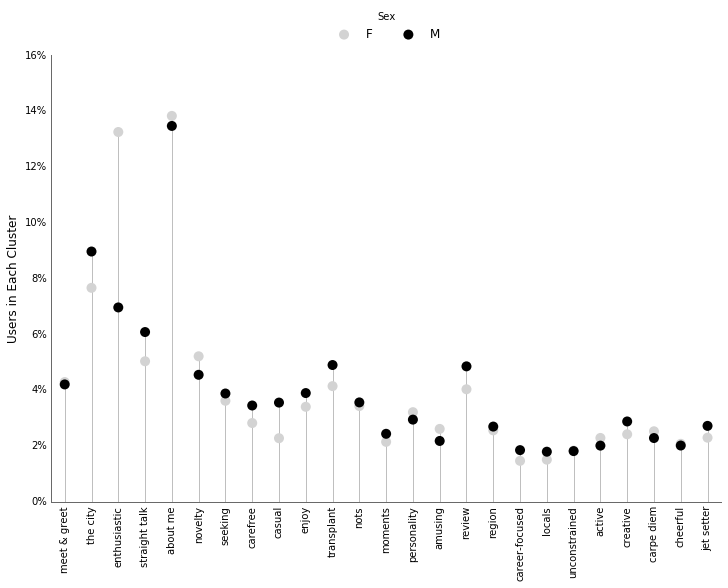

In [19]:
demog = 'sex'
subset = subset_df(df_0, demog, ['F', 'M'])
grouped = group_pct(subset, demog)
lollipop_paper(grouped, demog, topic_labels=labels)

### Essay 4

#### Text Representation

In [20]:
counts, tfidf, vocab = feature_vectors(df_4.essay4, specs)

In [21]:
len(vocab)

2898

#### Clustering

In [22]:
K = 25
nmf_inspect(tfidf, vocab, k_vals=[K], n_words=50)

25
Group 0:
like | music like | movies like | really | really like | stuff | food like | things | like music | books like | like movies | n't like | like food | movies | lot | stuff like | like lot | like read | kind | comedies | like good | music | good | shows like | things like | like books | think | like reading | make | different | like watch | especially | old | like kinds | feel | like eat | like types | just | people | bands | pretty | feel like | funny | probably | like cook | eat | ones | nt | lots | metal

Group 1:
men | mad | mad men | arrested | development | arrested development | bad | breaking | breaking bad | rock | 30 | 30 rock | tv | parks | sunny | wire | dexter | shows | office | curb | sunny philadelphia | 's sunny | philadelphia | rec | parks rec | community | curb enthusiasm | enthusiasm | recreation | parks recreation | 's sunny philadelphia | daily | seinfeld | tv shows | archer | shows arrested | weeds | shows arrested development | colbert | louie | lost | c

In [23]:
labels = ['like', 'TV-hits', 'enthusiastic', 'favorite-0', 'genres-movies', 'genres-music',
          'misc-0', 'TV-comedies-0', 'genres-food', 'nots', 'teen', 'everything',
          'movies-drama-0', 'time periods', 'avid', 'miscellaneous', 'music-rock',
          'movies-sci-fi', 'TV-comedies-1', 'movies-drama-1', 'kinds', 'favorite-1',
          'novelty', 'TV-drama', 'genres-books']

In [24]:
df_4['group'] = nmf_labels(tfidf, k=K)

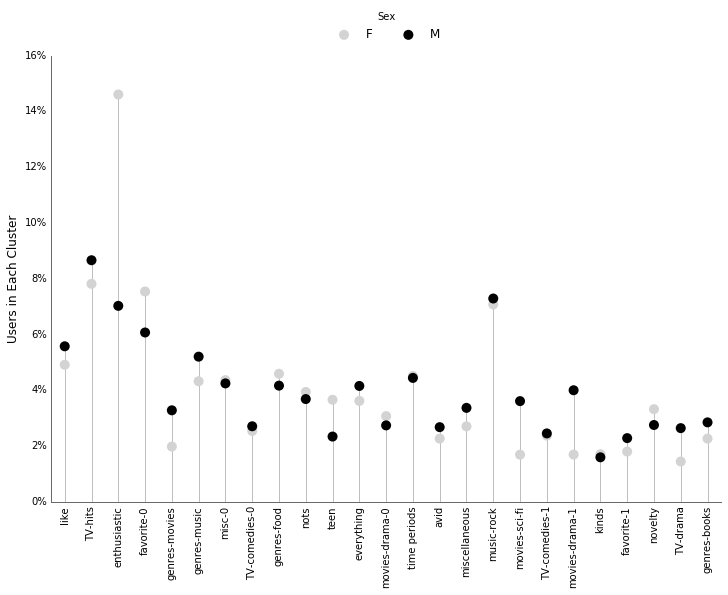

In [25]:
demog = 'sex'
subset = subset_df(df_4, demog, ['M', 'F'])
grouped = group_pct(subset, demog)
lollipop_paper(grouped, demog, topic_labels=labels)

#### Superordinate

In [26]:
mask = df_4['group'].isin([10, 12, 17, 19])
movies = counts[np.array(mask), :]
movies = counts_by_class(movies, df_4[mask], 'sex',
                         one_vs_one=True, vals=['M', 'F'])
log_odds = log_odds_ratio(movies, vocab, use_variance=True)

In [27]:
print_terms(log_odds, 15)

star | star wars | wars | matrix | fight | park | fight club | man | dark knight | knight | pulp | godfather | trek | star trek | rings

love | girl | harry | potter | pride | prejudice | harry potter | pride prejudice | bones | girls | anatomy | jane | hunger games | grey 's | 's anatomy


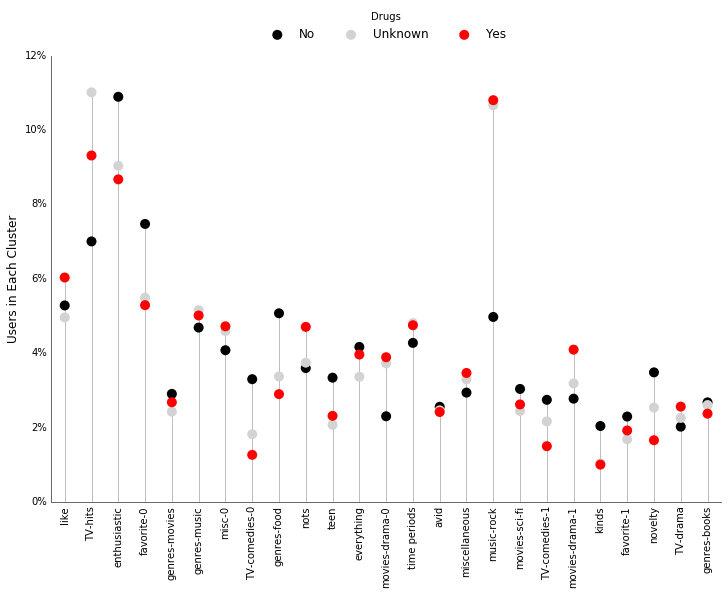

In [28]:
demog = 'drugs'
subset = subset_df(df_4, demog, ['yes', 'no', 'unknown'])
grouped = group_pct(subset, demog)
lollipop_paper(grouped, demog, colors=['Black', 'LightGray', 'Red'], topic_labels=labels)

## Predictions

In [29]:
def drug_labels(df):
    labels = []
    for i in df.index:
        if df.drugs[i] in ('no', 'unknown'):
            labels.append(0)
        elif df.drugs[i] == 'yes':
            labels.append(1)
    return labels

### Essay 4

In [30]:
# numerical drug usage labels
df_4['labels'] = drug_labels(df_4)

# split on drug usage status
drugs_yes = subset_df(df_4, 'drugs', ['yes'])
drugs_no = subset_df(df_4, 'drugs', ['no'])
drugs_unknown = subset_df(df_4, 'drugs', ['unknown'])

# balanced sample of known drug users
drugs_known_sample = pd.concat([drugs_no.sample(drugs_yes.shape[0],
                                                random_state=42),
                                drugs_yes],
                               ignore_index=True)

In [31]:
pred_4 = {'vocabulary' : vocab}
_, known, _ = feature_vectors(drugs_known_sample.essay4, pred_4)
_, unknown, _ = feature_vectors(drugs_unknown.essay4, pred_4)

In [32]:
known_train, known_test, y_train, y_test = train_test_split(known,
                                                            drugs_known_sample['labels'],
                                                            test_size=0.2, random_state=42)

In [33]:
model = LogisticRegression()
model.fit(known_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
yhat = model.predict(known_test)
print(accuracy_score(y_test, yhat))

0.680029154519


In [35]:
drugs_unknown['yhat'] = model.predict(unknown)
print(drugs_unknown.yhat.sum() / drugs_unknown.shape[0])

0.552282893071


In [36]:
drugs_unknown.groupby('group')['yhat'].mean().sort_values()

group
20    0.243902
7     0.245370
18    0.295720
8     0.312500
10    0.313008
22    0.352159
2     0.388422
3     0.436252
11    0.461153
17    0.482759
21    0.500000
24    0.501618
14    0.506849
4     0.517361
13    0.577193
23    0.585821
0     0.593537
6     0.598165
5     0.621931
9     0.626126
1     0.631418
15    0.649616
12    0.660633
19    0.661376
16    0.840190
Name: yhat, dtype: float64

### All Essays

"Tell me something I don't know. Can I predict drug usage status based on text alone? How well? Then, find the terms that are most indicative of drug usage.

In [37]:
essay_list = ['essay' + str(i) for i in range(10)]
df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9 = clean_up(df,
                                                                      essay_list,
                                                                      min_words=0)

In [38]:
# combine all essays
essays = df_0.essay0.str.cat([df_1.essay1, df_2.essay2, df_3.essay3,
                              df_4.essay4, df_5.essay5, df_6.essay6,
                              df_7.essay7, df_8.essay8, df_9.essay9], sep=' ')
df_0['essays'] = essays

df_0 = recategorize(df_0)

In [39]:
# only keep observations with more than five tokens
all_essays = df_0[df_0.essays.str.split().str.len() > 5]
all_essays.shape, df.shape

((57490, 34), (59946, 32))

In [40]:
# numerical drug usage labels
all_essays['labels'] = drug_labels(all_essays)

# split on drug usage status
drugs_yes = subset_df(all_essays, 'drugs', ['yes'])
drugs_no = subset_df(all_essays, 'drugs', ['no'])
drugs_unknown = subset_df(all_essays, 'drugs', ['unknown'])

# balanced sample of known drug users
drugs_known_sample = pd.concat([drugs_no.sample(drugs_yes.shape[0],
                                                random_state=42),
                                drugs_yes],
                               ignore_index=True)

In [41]:
# vocabulary for all essays
_, _, all_vocab = feature_vectors(all_essays.essays, specs)
print(len(all_vocab))

6835


In [42]:
pred_all = {'vocabulary' : all_vocab}
_, known, _ = feature_vectors(drugs_known_sample.essays, pred_all)
_, unknown, _ = feature_vectors(drugs_unknown.essays, pred_all)

In [43]:
known_train, known_test, y_train, y_test = train_test_split(known,
                                                            drugs_known_sample['labels'],
                                                            test_size=0.2, random_state=42)

In [44]:
model = LogisticRegression()
model.fit(known_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
yhat = model.predict(known_test)
print(accuracy_score(y_test, yhat))

0.727417302799


In [46]:
drugs_unknown['yhat'] = model.predict(unknown)

In [47]:
print(drugs_unknown.yhat.sum() / drugs_unknown.shape[0])

0.524143472861


#### Most Predictive Terms

In [48]:
token_dict = {coeff : i for i, coeff in enumerate(model.coef_[0])}

In [49]:
coefficients = model.coef_[0]
coefficients.sort()

In [50]:
import numpy as np

In [51]:
for i in range(1, 26):
    print(all_vocab[token_dict[coefficients[-i]]] + ' (' + 
          str(np.round(np.exp(coefficients[-i]), 2)) + ')', end=', ')

sex (68.96), shit (45.51), music (20.95), weed (18.46), party (15.54), beer (14.18), dubstep (13.86), fuck (12.28), drinking (11.48), smoking (11.39), partying (10.59), chill (9.45), hair (8.84), park (8.09), fucking (7.93), dj (7.9), burning (7.78), electronic (7.05), drunk (6.67), ass (6.36), reggae (6.18), robbins (5.81), dude (5.74), smoke (5.68), cat (5.5), 